In [1]:
from sparky import Sparky
spark = Sparky(appname='SparkySampleApp')
spark.sqlContext

In [2]:
import os
import sys
from glob import glob

from IPython.display import display, Markdown
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)
import datetime
from datetime import date, timedelta
from pytz import timezone
from datetime import datetime

from pyspark.sql.functions import *
from pyspark.sql.functions import concat, col, lit
from pyspark.sql.types import *

from pyspark import SparkContext
from pyspark.sql.types import DoubleType
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import DataFrameWriter as W

import pandas as pd
import json
import numpy as np

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
spark = SparkSession.builder.master("yarn").appName("realTimeGPS").getOrCreate()

In [4]:
from IPython.display import display, Markdown
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)


In [8]:
updateDay=(date.today()).strftime('%Y%m%d')
# updateDay = (date.today()-timedelta(1)).strftime('%Y%m%d')
updateDay

'20190815'

In [9]:
sourceDataDayPath1 = ("/apps/data/internal/db.trips/iotp.core.device.driving.realTimeGPSEvent.delayed.json/"+updateDay+"/")
sourceDataDayPath2 = ("/apps/data/internal/db.trips/iotp.core.device.driving.realTimeGPSEvent.future.processed.json/"+updateDay+"/")
sourceDataDayPath3 = ("/apps/data/internal/db.trips/iotp.core.device.driving.realTimeGPSEvent.trimmed.json/"+updateDay+"/")
sourceDataDayPath4 = ("/apps/data/internal/db.trips/iotp.core.device.realTimeGPSEvent.processed.avro/"+updateDay+"/")


In [10]:
df = spark.read.option("multiLine",True).option("mode", "PERMISSIVE").json(sourceDataDayPath1)
df1 = spark.read.option("multiLine",True).option("mode", "PERMISSIVE").json(sourceDataDayPath2)
df2 = spark.read.option("multiLine",True).option("mode", "PERMISSIVE").json(sourceDataDayPath3).drop("_corrupt_record")
df3 = spark.read.format("com.databricks.spark.avro").load(sourceDataDayPath4)

In [11]:
delayed_df = df.withColumn("error_date",split(col("error_TS"),"T").getItem(0)).withColumn("error_hour",concat(split(col("error_TS"),"T").getItem(1)[0:2],lit(":00:00"))).withColumn("loadDate",date_sub(current_timestamp(),0))
future_df = df1.withColumn("error_date",split(col("error_TS"),"T").getItem(0)).withColumn("error_hour",concat(split(col("error_TS"),"T").getItem(1)[0:2],lit(":00:00"))).withColumn("loadDate",date_sub(current_timestamp(),0))
trimmed_df = df2.withColumn("error_date",split(col("error_TS"),"T").getItem(0)).withColumn("error_hour",concat(split(col("error_TS"),"T").getItem(1)[0:2],lit(":00:00"))).withColumn("loadDate",date_sub(current_timestamp(),0))

In [29]:
updateDay = (date.today()).strftime('%Y-%m-%d')
# updateDay = (date.today()-timedelta(1)).strftime('%Y-%m-%d')
updateDay

'2019-08-15'

In [30]:
gpsPoints = df3.withColumn("unix_gatewayTS",(unix_timestamp("gatewayReceived_TS"))+14400)\
.withColumn("transformed_TS",from_unixtime("unix_gatewayTS")).withColumn("gateway_date",split(col("transformed_TS")," ").getItem(0))\
.withColumn("gateway_hour",concat(split(col("transformed_TS")," ").getItem(1)[0:2],lit(":00:00")))\
.withColumn("unique_id",concat("tripId","imei"))
gpsPoints1=gpsPoints.filter(col('gateway_date')==updateDay)
gpsPoints1.registerTempTable("gpsTBL")

In [31]:
from functools import reduce  # For Python 3.x
from pyspark.sql import DataFrame

In [32]:
def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

In [33]:
# new_df = Seq(delayed_df, future_df, trimmed_df)
new_df=unionAll(delayed_df, future_df, trimmed_df)
new_df1=new_df.filter(col('error_date')==updateDay)

In [34]:
df=new_df1.select("deviceId","error_TS",explode("errors"),"organizationId","tripId","error_date","error_hour")\
.select("col.*","*").withColumn("unique_id",concat("tripId","deviceId")).drop("col").drop("link").drop("field").drop("extension")
df.registerTempTable("tbl1")


In [35]:
df2 = spark.sql("select error_date, error_hour, organizationId as orgId, unique_id, deviceId, code, case when code='499.07.116' then 'delayed_gps' end as delayedPoints, case when code='499.07.117' then 'future_gps' end as futurePoints, case when code='499.07.118' then 'trimmed_gps' end as trimmedPoints from tbl1")

df2.registerTempTable("tbl2")

In [36]:
df5 = spark.sql("select error_hour, count(delayedPoints) as delayedGPS, count(futurePoints) as futureGPS, count(trimmedPoints) as trimmedGPS from tbl2 group by error_hour")
df5.registerTempTable("errorsDF")

df6 = spark.sql("select gateway_hour, count(*) as total_points from gpsTBL group by gateway_hour")
df6.registerTempTable("gpsDF")


In [37]:
joinedDF = df6.join(df5, df5.error_hour == df6.gateway_hour, "fullouter")

In [38]:
df = joinedDF.withColumn(
    'gps_hour', when((col("gateway_hour").isNull()), joinedDF.error_hour).otherwise(joinedDF.gateway_hour)).drop("gateway_hour").drop("error_hour")

In [39]:
# temp1=df5.toPandas()
# temp2=df6.toPandas()

In [40]:
# temp1=temp1.sort_values('error_hour').reset_index(drop=True)
# temp2=temp2.sort_values('gateway_hour').reset_index(drop=True)

In [41]:
temp3=df.toPandas()
temp3=temp3.sort_values('gps_hour').reset_index(drop=True)

In [42]:
temp3['publishedGPS']=temp3['total_points']-temp3['delayedGPS']-temp3['futureGPS']-temp3['trimmedGPS']
temp3=temp3[['gps_hour','total_points','publishedGPS','delayedGPS','futureGPS','trimmedGPS']]

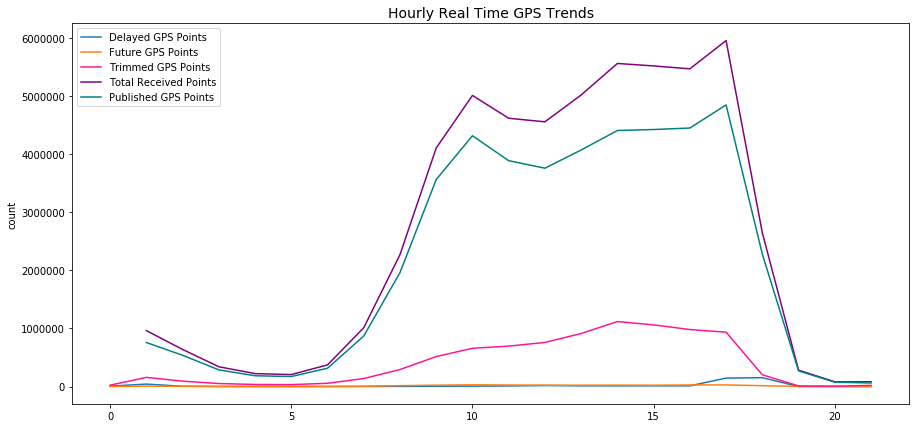

In [43]:
#draw
fig=plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,1,1)  

plt.plot(temp3['delayedGPS'],label='Delayed GPS Points')
plt.plot(temp3['futureGPS'],label='Future GPS Points')
plt.plot(temp3['trimmedGPS'],label='Trimmed GPS Points',color='deeppink')
plt.plot(temp3['total_points'],label='Total Received Points',color='purple')
plt.plot(temp3['publishedGPS'],label='Published GPS Points',color='teal')
x = range(0,len(temp3['gps_hour']),24)

# labels=temp3['gps_hour'][::24]
# ax.set_xticks(np.arange(len(x)))
# plt.xticks(x, rotation='vertical')

# fig.autofmt_xdate()
plt.legend(loc='upper left')
plt.title("Hourly Real Time GPS Trends",fontsize=14)
plt.ylabel('count');

In [44]:
temp3

,gps_hour,total_points,publishedGPS,delayedGPS,futureGPS,trimmedGPS
0,02:00:00,NaN,NaN,6760,294,22839
1,03:00:00,962917.0,757912.0,41990,5788,157227
2,04:00:00,638619.0,537898.0,4261,4211,92249
3,05:00:00,340363.0,286642.0,491,2178,51052
4,06:00:00,222309.0,185168.0,317,1278,35546
5,07:00:00,205859.0,172175.0,194,1236,32254
6,08:00:00,372497.0,314948.0,366,1537,55646
7,09:00:00,1012636.0,869888.0,791,4663,137294
8,10:00:00,2272053.0,1962816.0,1948,14953,292336
9,11:00:00,4108641.0,3565665.0,3856,23321,515799


In [45]:
print("Total Received GPS Points (today):",np.sum(temp3.total_points))
print("Total Published GPS Points (today):", np.sum(temp3.publishedGPS))
print("Total Delayed GPS Points (today):",np.sum(temp3.delayedGPS))
print("Total Trimmed GPS Points (today):",np.sum(temp3.trimmedGPS))
print("Total Future GPS Points (today):",np.sum(temp3.futureGPS))

Total Received GPS Points (today): 54962563.0
Total Published GPS Points (today): 45521162.0
Total Delayed GPS Points (today): 438902
Total Trimmed GPS Points (today): 8754151
Total Future GPS Points (today): 278241
